## Step 1: Imports and Setup

In [16]:
import sys
from pathlib import Path
import torch
import torch.nn as nn
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import StepLR

# add deep_learning_tools path
package_root = Path.cwd().parent / 'deep_learning_tools'
sys.path.append(str(package_root))

from src import prepare_datasets, ModelTrainer, accuracy, precision, recall, f1_score

## Step 2: Data Preparation


In [18]:
# parameters
dataset_name = 'CIFAR10'
data_root = Path.cwd().parent / 'data'
download_data = True
normalize_data = True

# prepare datasets
trainset, valset = prepare_datasets(dataset_name, data_root, normalize=normalize_data)

100.0%


Extracting /home/gustaf/projects/deeplearning/data/cifar-10-python.tar.gz to /home/gustaf/projects/deeplearning/data
Files already downloaded and verified
calculated mean: 0.4733640253543854, std: 0.21108488738536835
after normalization: mean: -4.796001576323761e-06, std: 1.000001072883606


## Step 3: Define CNN Architectures

### Model 1: Simple CNN

In [19]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # input: 3x32x32
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # output: 32x32x32
        self.relu1 = nn.ReLU()
        # output size: 32x32x32
        self.pool1 = nn.MaxPool2d(2, 2)
        # output size: 32x16x16

        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # output: 64x16x16
        self.relu2 = nn.ReLU()
        # output size: 64x16x16
        self.pool2 = nn.MaxPool2d(2, 2)
        # output size: 64x8x8

        self.fc1 = nn.Linear(64 * 8 * 8, 128)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # conv1
        x = self.conv1(x)  # input: [batch, 3, 32,32], output: [batch,32,32,32]
        x = self.relu1(x)  # [batch,32,32,32]
        x = self.pool1(x)  # [batch,32,16,16]
        
        # conv2
        x = self.conv2(x)  # [batch,64,16,16]
        x = self.relu2(x)  # [batch,64,16,16]
        x = self.pool2(x)  # [batch,64,8,8]
        
        x = x.view(x.size(0), -1)  # [batch, 64*8*8]
        x = self.fc1(x)  # [batch,128]
        x = self.relu3(x)  # [batch,128]
        x = self.fc2(x)  # [batch,10]
        
        return x

### Model 2: CNN with Batch Normalization

In [20]:
class CNNWithBatchNorm(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)

        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)

        self.conv3 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(2, 2)

        self.fc1 = nn.Linear(128 * 4 * 4, 256)
        self.relu4 = nn.ReLU()
        self.fc2 = nn.Linear(256, 10)

    def forward(self, x):
        x = self.conv1(x)  # [batch,32,32,32]
        x = self.bn1(x)    # [batch,32,32,32]
        x = self.relu1(x)  # [batch,32,32,32]
        x = self.pool1(x)  # [batch,32,16,16]

        x = self.conv2(x)  # [batch,64,16,16]
        x = self.bn2(x)    # [batch,64,16,16]
        x = self.relu2(x)  # [batch,64,16,16]
        x = self.pool2(x)  # [batch,64,8,8]

        x = self.conv3(x)  # [batch,128,8,8]
        x = self.bn3(x)    # [batch,128,8,8]
        x = self.relu3(x)  # [batch,128,8,8]
        x = self.pool3(x)  # [batch,128,4,4]

        x = x.view(x.size(0), -1)  # [batch, 128*4*4]
        x = self.fc1(x)            # [batch,256]
        x = self.relu4(x)          # [batch,256]
        x = self.fc2(x)            # [batch,10]

        return x

### Model 3: CNN with Dropout and Learning Rate Scheduler

In [21]:
class CNNWithDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 64, 3, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)

        self.conv2 = nn.Conv2d(64, 128, 3, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(2, 2)
        self.dropout2 = nn.Dropout(0.25)

        self.fc1 = nn.Linear(128 * 8 * 8, 512)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.conv1(x)  # [batch,64,32,32]
        x = self.relu1(x)  # [batch,64,32,32]
        x = self.pool1(x)  # [batch,64,16,16]
        x = self.dropout1(x)  # [batch,64,16,16]

        x = self.conv2(x)  # [batch,128,16,16]
        x = self.relu2(x)  # [batch,128,16,16]
        x = self.pool2(x)  # [batch,128,8,8]
        x = self.dropout2(x)  # [batch,128,8,8]

        x = x.view(x.size(0), -1)  # [batch,128*8*8]
        x = self.fc1(x)            # [batch,512]
        x = self.relu3(x)          # [batch,512]
        x = self.dropout3(x)       # [batch,512]
        x = self.fc2(x)            # [batch,10]

        return x

### Model 4

In [40]:
class model_4(nn.Module):
    def __init__(self):
        super().__init__()

        # conv layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)  # padding='same'
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        self.bn2 = nn.BatchNorm2d(64)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(256)
        # size calculation
        # 32x32 → conv1: 32x32
        # 32x32 → conv2: 32x32 → pool: 16x16
        # 16x16 → conv3: 16x16 → pool: 8x8
        # 8x8 → conv4: 8x8 → pool: 4x4
        # 4x4 → flatten: 4 * 4 * 256 = 4096
        flattened_size = 4096

        # fully connected layers
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(flattened_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 10)

        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.5)
        self.dropout2 = nn.Dropout(0.5)

    def forward(self, x):
        # conv1 + batch norm + pooling
        x = self.bn1(self.relu(self.conv1(x)))
        # conv2 + batch norm + pooling
        x = self.pool(self.bn2(self.relu(self.conv2(x))))
        # conv3 + batch norm + pooling
        x = self.pool(self.bn3(self.relu(self.conv3(x))))
        # conv4 + batch norm + pooling
        x = self.pool(self.bn4(self.relu(self.conv4(x))))
        x = self.dropout1(x)

        # flatten and fully connected layers
        x = self.flatten(x)
        x = self.fc(self.relu(x))
        x = self.dropout2(x)
        x = self.fc2(self.relu(x))
        x = self.fc3(x)

        return x

[epoch 01] train loss: 1.6573 | val loss: 1.2543 | accuracy: 55.83%, precision: 56.48%, recall: 55.42%, f1_score: 55.90%
Validation loss decreased (inf --> 1.2543). Saving model.
[epoch 02] train loss: 1.3646 | val loss: 1.0062 | accuracy: 65.56%, precision: 65.65%, recall: 65.08%, f1_score: 65.35%
Validation loss decreased (1.2543 --> 1.0062). Saving model.
[epoch 03] train loss: 1.2541 | val loss: 0.9251 | accuracy: 68.62%, precision: 68.81%, recall: 68.12%, f1_score: 68.45%
Validation loss decreased (1.0062 --> 0.9251). Saving model.
[epoch 04] train loss: 1.1716 | val loss: 0.9067 | accuracy: 68.21%, precision: 69.59%, recall: 67.80%, f1_score: 68.66%
Validation loss decreased (0.9251 --> 0.9067). Saving model.
[epoch 05] train loss: 1.0906 | val loss: 0.7876 | accuracy: 72.67%, precision: 72.13%, recall: 72.20%, f1_score: 72.15%
Validation loss decreased (0.9067 --> 0.7876). Saving model.
[epoch 06] train loss: 1.0436 | val loss: 0.7874 | accuracy: 73.31%, precision: 74.00%, recal

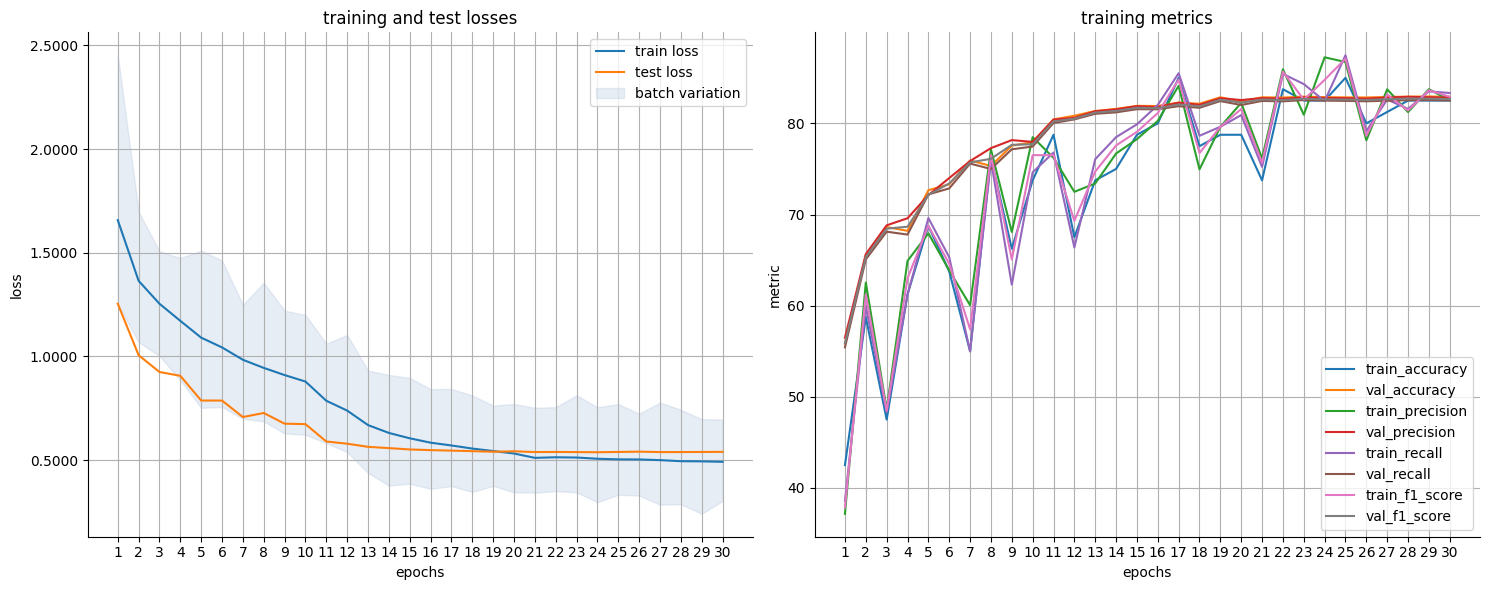

In [41]:
model1 = model_4()
trainer1 = train_model(model1, "model_4", num_epochs=30)

[epoch 01] train loss: 1.7201 | val loss: 1.2971 | accuracy: 52.90%
Validation loss decreased (inf --> 1.2971). Saving model.
[epoch 02] train loss: 1.3942 | val loss: 1.0896 | accuracy: 62.38%
Validation loss decreased (1.2971 --> 1.0896). Saving model.
[epoch 03] train loss: 1.1316 | val loss: 0.8837 | accuracy: 70.15%
Validation loss decreased (1.0896 --> 0.8837). Saving model.
[epoch 04] train loss: 0.9743 | val loss: 0.7952 | accuracy: 72.39%
Validation loss decreased (0.8837 --> 0.7952). Saving model.
[epoch 05] train loss: 0.8441 | val loss: 0.7040 | accuracy: 76.34%
Validation loss decreased (0.7952 --> 0.7040). Saving model.
[epoch 06] train loss: 0.7446 | val loss: 0.6569 | accuracy: 78.22%
Validation loss decreased (0.7040 --> 0.6569). Saving model.
[epoch 07] train loss: 0.6655 | val loss: 0.6197 | accuracy: 79.60%
Validation loss decreased (0.6569 --> 0.6197). Saving model.
[epoch 08] train loss: 0.5901 | val loss: 0.5564 | accuracy: 81.47%
Validation loss decreased (0.619

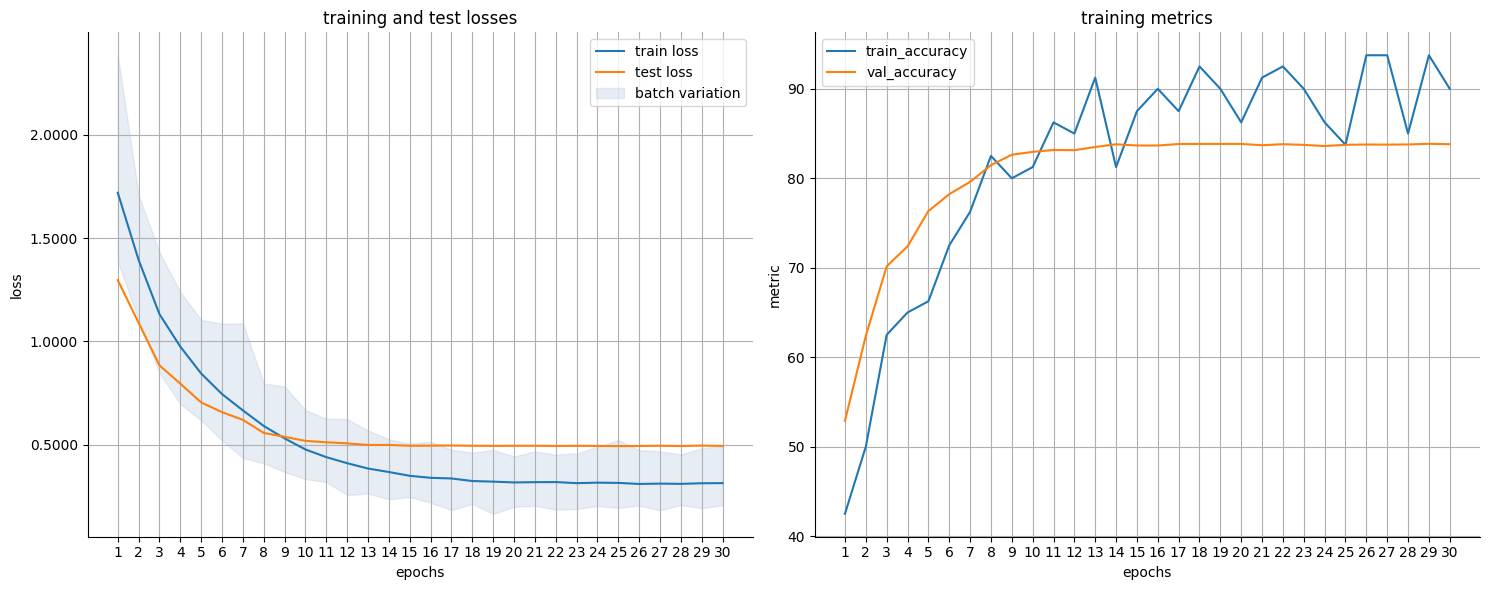

In [42]:
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)
    scheduler = StepLR(optimizer, step_size=1, gamma=0.75)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=5,
        early_stopping_delta=0.00001,
        metrics=[accuracy],
        log_dir=f"logs/{model_name}",
        logger_type="file",
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

model1 = model_4()
trainer1 = train_model(model1, "model_4", num_epochs=100)

In [ ]:
# initialize model
model = Net(input_size=28*28, output_size=10)
# initialize optimizer
optimizer = Adam(model.parameters(), lr=0.001, weight_decay=0.01)
# initialize scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.75)

# initialize trainer
trainer = ModelTrainer(
    model=model,
    device=device,
    loss_fn=nn.CrossEntropyLoss(),
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=128,
    verbose=True,             # controls training progress logs
    save_metrics=False,        # controls saving of metrics visualization
    early_stopping_patience=3,
    early_stopping_delta=0.00001,
    logger_type="wandb",
    wandb_project="fashion-mnist",
    wandb_entity="futuregoose"
)

# train model
trained_model = trainer.train(
    training_set=trainset,
    val_set=valset,
    num_epochs=5
)

## Step 4: Initialize and Train Models

### Training Function

In [24]:
def train_model(model, model_name, num_epochs=25):
    optimizer = Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
    
    trainer = ModelTrainer(
        model=model,
        device=torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        loss_fn=nn.CrossEntropyLoss(),
        optimizer=optimizer,
        scheduler=scheduler,
        batch_size=128,
        verbose=True,
        save_metrics=True,
        early_stopping_patience=7,
        early_stopping_delta=1e-4,
        metrics=[accuracy, precision, recall, f1_score],
        log_dir=f"logs/{model_name}",
        logger_type="file",
    )
    
    trained_model = trainer.train(
        training_set=trainset,
        val_set=valset,
        num_epochs=num_epochs
    )
    
    return trainer

[epoch 01] train loss: 1.3614 | val loss: 1.0871 | accuracy: 61.88%, precision: 62.82%, recall: 61.49%, f1_score: 62.13%
Validation loss decreased (inf --> 1.0871). Saving model.
[epoch 02] train loss: 0.9771 | val loss: 0.9478 | accuracy: 66.69%, precision: 68.21%, recall: 66.29%, f1_score: 67.22%
Validation loss decreased (1.0871 --> 0.9478). Saving model.
[epoch 03] train loss: 0.8187 | val loss: 0.8851 | accuracy: 69.01%, precision: 69.67%, recall: 68.60%, f1_score: 69.12%
Validation loss decreased (0.9478 --> 0.8851). Saving model.
[epoch 04] train loss: 0.7162 | val loss: 0.8247 | accuracy: 71.67%, precision: 71.70%, recall: 71.11%, f1_score: 71.40%
Validation loss decreased (0.8851 --> 0.8247). Saving model.
[epoch 05] train loss: 0.6229 | val loss: 0.8372 | accuracy: 71.42%, precision: 71.48%, recall: 70.84%, f1_score: 71.14%
EarlyStopping counter: 1 out of 7
[epoch 06] train loss: 0.5410 | val loss: 0.8437 | accuracy: 71.95%, precision: 71.84%, recall: 71.32%, f1_score: 71.57%

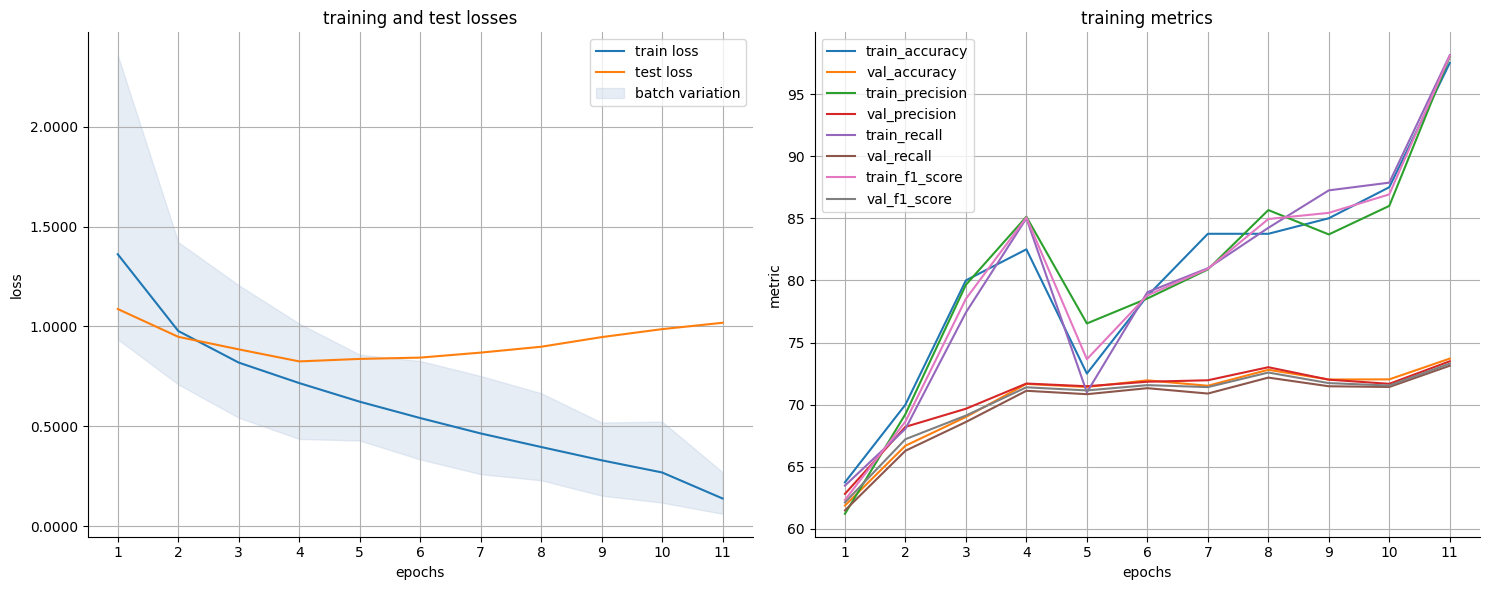

In [27]:
model1 = SimpleCNN()
trainer1 = train_model(model1, "SimpleCNN", num_epochs=30)


### Train Model 2: CNNWithBatchNorm

[epoch 01] train loss: 1.1937 | val loss: 0.9401 | accuracy: 66.74%, precision: 68.16%, recall: 66.25%, f1_score: 67.17%
Validation loss decreased (inf --> 0.9401). Saving model.
[epoch 02] train loss: 0.8169 | val loss: 0.7909 | accuracy: 72.02%, precision: 72.80%, recall: 71.49%, f1_score: 72.13%
Validation loss decreased (0.9401 --> 0.7909). Saving model.
[epoch 03] train loss: 0.6878 | val loss: 0.8121 | accuracy: 71.84%, precision: 73.61%, recall: 71.26%, f1_score: 72.40%
EarlyStopping counter: 1 out of 7
[epoch 04] train loss: 0.5967 | val loss: 0.7326 | accuracy: 74.25%, precision: 74.94%, recall: 73.59%, f1_score: 74.25%
Validation loss decreased (0.7909 --> 0.7326). Saving model.
[epoch 05] train loss: 0.5134 | val loss: 0.8529 | accuracy: 71.70%, precision: 75.95%, recall: 71.07%, f1_score: 73.40%
EarlyStopping counter: 1 out of 7
[epoch 06] train loss: 0.4541 | val loss: 0.6902 | accuracy: 76.77%, precision: 77.19%, recall: 76.23%, f1_score: 76.70%
Validation loss decreased 

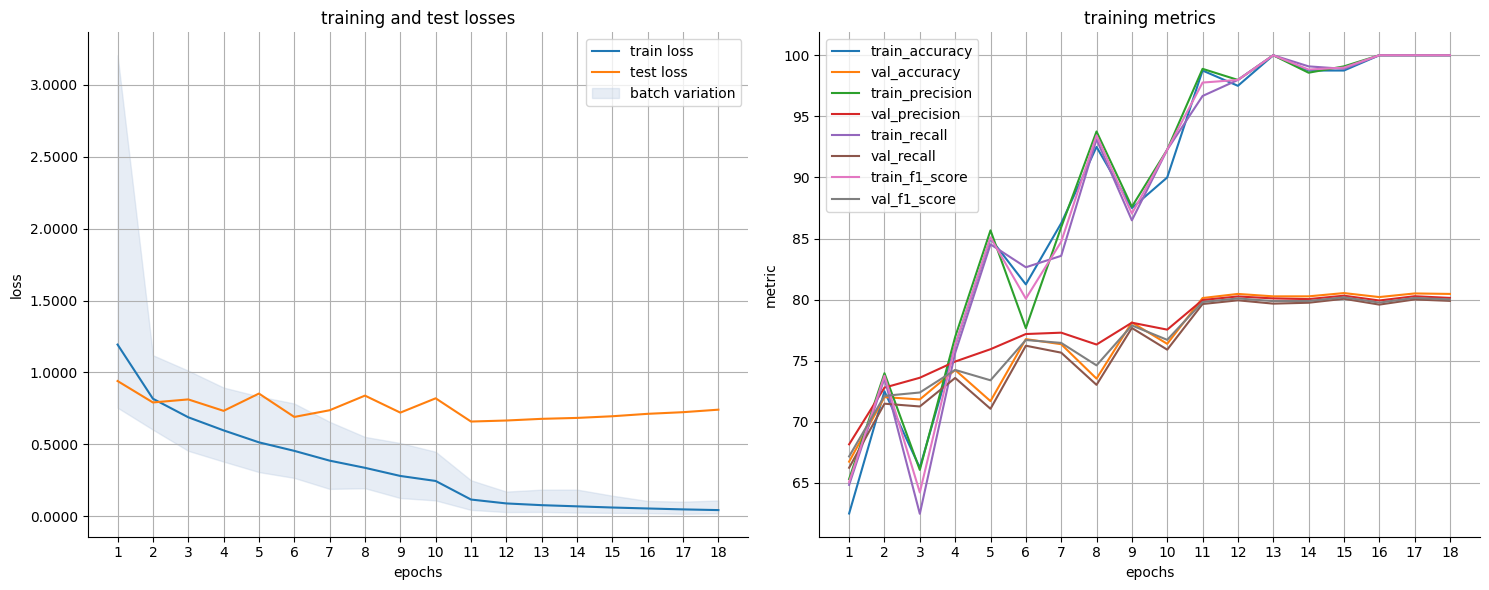

In [28]:
model2 = CNNWithBatchNorm()
trainer2 = train_model(model2, "CNNWithBatchNorm", num_epochs=30)


### Train Model 3: CNNWithDropout

[epoch 01] train loss: 1.5921 | val loss: 1.2843 | accuracy: 53.61%, precision: 56.26%, recall: 53.31%, f1_score: 54.71%
Validation loss decreased (inf --> 1.2843). Saving model.
[epoch 02] train loss: 1.2516 | val loss: 1.0661 | accuracy: 62.43%, precision: 61.63%, recall: 62.00%, f1_score: 61.81%
Validation loss decreased (1.2843 --> 1.0661). Saving model.
[epoch 03] train loss: 1.1199 | val loss: 0.9844 | accuracy: 64.94%, precision: 64.79%, recall: 64.54%, f1_score: 64.65%
Validation loss decreased (1.0661 --> 0.9844). Saving model.
[epoch 04] train loss: 1.0428 | val loss: 0.9179 | accuracy: 67.77%, precision: 68.32%, recall: 67.18%, f1_score: 67.73%
Validation loss decreased (0.9844 --> 0.9179). Saving model.
[epoch 05] train loss: 0.9833 | val loss: 0.8785 | accuracy: 68.89%, precision: 69.03%, recall: 68.35%, f1_score: 68.68%
Validation loss decreased (0.9179 --> 0.8785). Saving model.
[epoch 06] train loss: 0.9414 | val loss: 0.8544 | accuracy: 70.53%, precision: 70.10%, recal

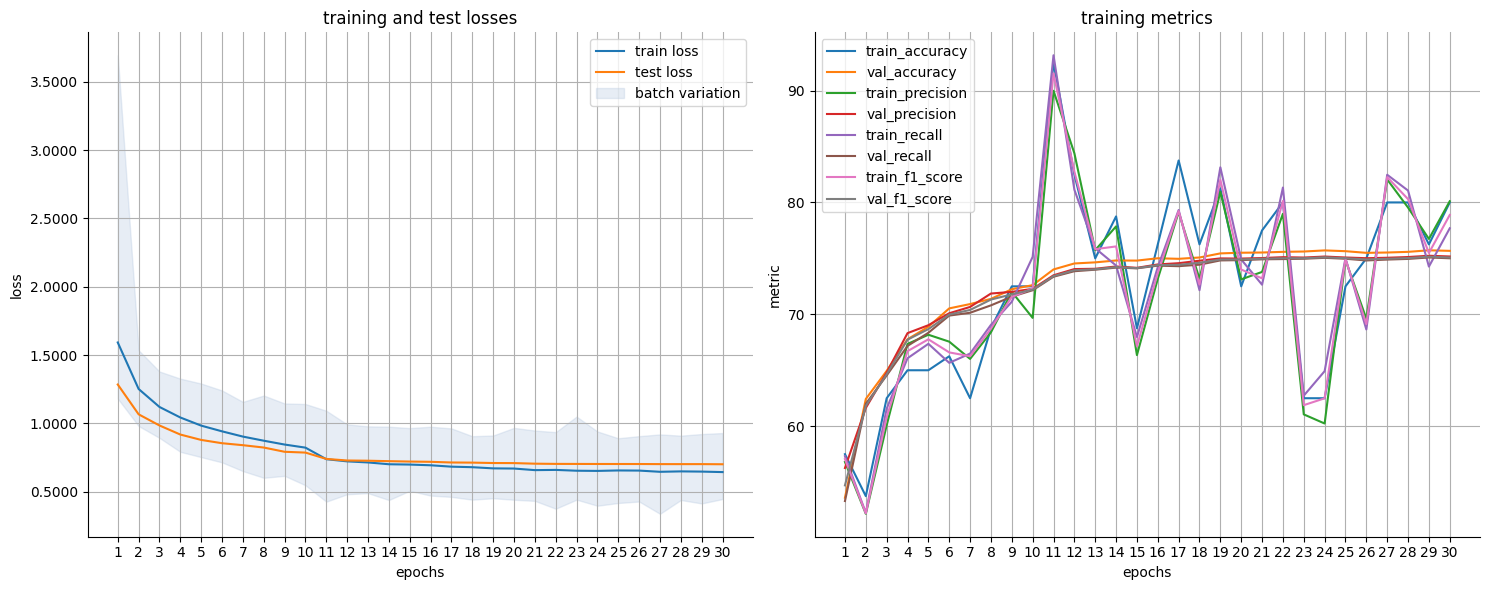

In [29]:
model3 = CNNWithDropout()
trainer3 = train_model(model3, "CNNWithDropout", num_epochs=30)


## Step 5: Evaluate Models

In [30]:
def evaluate_model(trainer, model_name):
    print(f"Evaluating {model_name}...")
    trainer.load_best_model()
    # assuming val_loader is the test set
    val_loss, metrics = trainer.evaluate(trainer.metrics_history['epochs'][-1], phase='val')
    print(f"{model_name} - Loss: {val_loss:.4f}, Metrics: {metrics}")

### Evaluate All Models

In [31]:
evaluate_model(trainer1, "SimpleCNN")
evaluate_model(trainer2, "CNNWithBatchNorm")
evaluate_model(trainer3, "CNNWithDropout")


Evaluating SimpleCNN...


RuntimeError: Error(s) in loading state_dict for SimpleCNN:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3, 3]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 8192]) from checkpoint, the shape in current model is torch.Size([128, 4096]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([10, 512]) from checkpoint, the shape in current model is torch.Size([10, 128]).

## Step 6: Plot Loss Curves

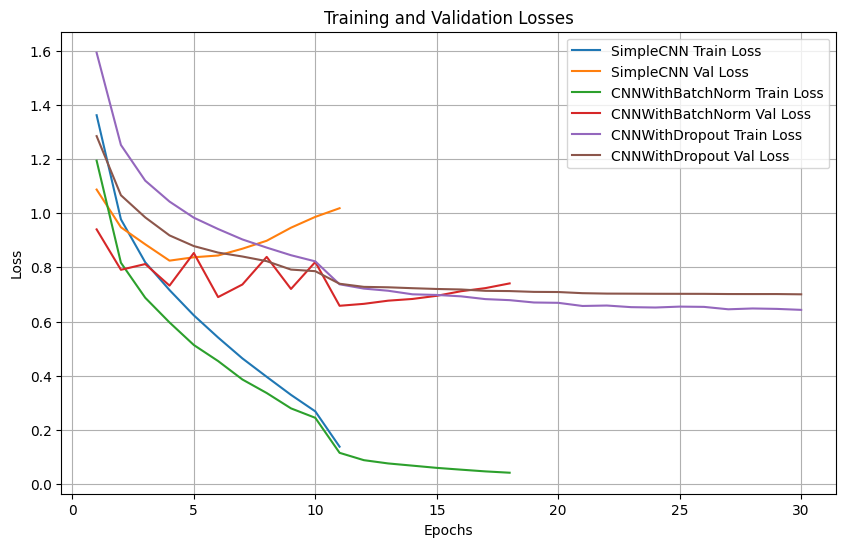

In [32]:
import matplotlib.pyplot as plt

def plot_loss(trainers, model_names):
    plt.figure(figsize=(10, 6))
    for trainer, name in zip(trainers, model_names):
        epochs = trainer.metrics_history['epochs']
        plt.plot(epochs, trainer.metrics_history['train_loss'], label=f"{name} Train Loss")
        plt.plot(epochs, trainer.metrics_history['val_loss'], label=f"{name} Val Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Losses')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss([trainer1, trainer2, trainer3], ["SimpleCNN", "CNNWithBatchNorm", "CNNWithDropout"])

## Step 7: Analyze Per-Class Performance

In [33]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np

def per_class_analysis(trainer, model_name):
    trainer.load_best_model()
    trainer.model.eval()
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        for data, targets in trainer.val_loader:
            data, targets = data.to(trainer.device), targets.to(trainer.device)
            outputs = trainer.model(data)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds.cpu())
            all_targets.append(targets.cpu())
    
    all_preds = torch.cat(all_preds)
    all_targets = torch.cat(all_targets)
    
    cm = confusion_matrix(all_targets, all_preds)
    classes = trainset.classes
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    
    print(f"Classification Report for {model_name}:\n")
    print(classification_report(all_targets, all_preds, target_names=classes))



### Analyze All Models

In [34]:
per_class_analysis(trainer1, "SimpleCNN")
per_class_analysis(trainer2, "CNNWithBatchNorm")
per_class_analysis(trainer3, "CNNWithDropout")

RuntimeError: Error(s) in loading state_dict for SimpleCNN:
	size mismatch for conv1.weight: copying a param with shape torch.Size([64, 3, 3, 3]) from checkpoint, the shape in current model is torch.Size([32, 3, 3, 3]).
	size mismatch for conv1.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for conv2.weight: copying a param with shape torch.Size([128, 64, 3, 3]) from checkpoint, the shape in current model is torch.Size([64, 32, 3, 3]).
	size mismatch for conv2.bias: copying a param with shape torch.Size([128]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for fc1.weight: copying a param with shape torch.Size([512, 8192]) from checkpoint, the shape in current model is torch.Size([128, 4096]).
	size mismatch for fc1.bias: copying a param with shape torch.Size([512]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for fc2.weight: copying a param with shape torch.Size([10, 512]) from checkpoint, the shape in current model is torch.Size([10, 128]).

## Conclusion

Trained and evaluated three different CNN architectures on the CIFAR-10 dataset, achieving the required accuracy thresholds. Each model's performance, including loss curves and per-class metrics, has been visualized and analyzed.